# Objetivo del notebook

Este fichero Jupyter tiene como objetivo diseñar una estructura de red convolucional, y entrenarla con el conjunto de datos procesado. Ademas, se plantea aplicar aumento de datos para el conjunto de entrenamiento.

Una vez entrenado y optimizado el modelo, podremos utilizarlo para enfrentar su rendimiento con el modelo base.

---

<br>
<br>
<br>

## Importar las librerías a utilizar

En la siguiente celda se importan todas las librerías que se utilizan en el presente fichero Jupyter.

In [1]:
# Librerías de procesamiento y manipulación de datos
import numpy as np

# Librerías de visualización
import matplotlib.pyplot as plt
import cv2 as cv

# Librerías para la construcción de la red convolucional
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Otros
import os
from tqdm import tqdm
import warnings

warnings.filterwarnings(action = "ignore")

---

<br>
<br>
<br>

## Genero un nuevo conjunto de datos completo para este modelo


In [2]:
# Defino un objeto de la clase ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
datasets_path = "../data/"
new_datasets_path = "../processed_data_aug/"

if not os.path.exists(new_datasets_path):
    os.mkdir(new_datasets_path)

# Itero cada uno de los subconjuntos en el directorio "data/"
for subset in tqdm(os.listdir(datasets_path)):

    if subset != ".ipynb_checkpoints":

        # Creo una nueva carpeta para cada uno de los subsets
        subset_path = os.path.join(new_datasets_path, subset)
        if not os.path.exists(subset_path):
            os.mkdir(subset_path)

        for class_ in os.listdir(os.path.join(datasets_path, subset)):
            
            # Creo una nueva carpeta para cada una de las clases
            class_path = os.path.join(subset_path, class_)
            if not os.path.exists(class_path):
                os.mkdir(class_path)

            # Para cada una de las clases, itero sobre el listado de imágenes contenido dentro, las cargo y proceso en memoria
            for image in tqdm(os.listdir(os.path.join(datasets_path, subset, class_))):
                
                img_path = os.path.join(datasets_path, subset, class_, image)
                img = cv.imread(img_path)

                if img is not None:
                    # Defino una copia de la imagen
                    img_resized = cv.resize(img, (224, 224))

                    # Transformo la copia a escala de grises
                    img_gray = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)

                    # Si el subset es "train", generamos 5 imágenes aumentadas
                    if subset == "train":
                        # Expandimos la dimensión de la imagen para que sea compatible con ImageDataGenerator
                        img_expanded = img_gray.reshape((1,) + img_gray.shape + (1,))
                        i = 0
                        for batch in datagen.flow(img_expanded, batch_size=1):
                            augmented_image = batch[0].reshape(img_gray.shape)
                            save_path = os.path.join(class_path, f"aug_{i}_{image}")
                            cv.imwrite(save_path, augmented_image * 255)  # Deshacemos el rescale
                            i += 1
                            if i >= 5:
                                break

                    # Defino la ruta de destino para la imagen procesada
                    save_path = os.path.join(class_path, image)
                    
                    # Conservo la copia dentro del directorio os.path.join(new_datasets_path, subset, class_)
                    cv.imwrite(save_path, img_gray)

                else:
                    print(f"Error al cargar la imagen {img_path}")

print("Procesamiento completado.")

100%|██████████| 238/238 [00:00<00:00, 270.78it/s]

  5%|▌         | 252/4606 [00:04<01:16, 57.01it/s]

Error al cargar la imagen ../data/train\fractured\159.jpg



  9%|▉         | 436/4606 [00:07<00:59, 69.58it/s]

Error al cargar la imagen ../data/train\fractured\2.jpg



 11%|█         | 491/4606 [00:08<01:11, 57.79it/s]

Error al cargar la imagen ../data/train\fractured\26(1).jpg



100%|██████████| 4606/4606 [01:05<00:00, 70.41it/s]

100%|██████████| 337/337 [00:02<00:00, 127.05it/s]

100%|██████████| 4/4 [02:20<00:00, 35.05s/it]

Procesamiento completado.


## Cargando el conjunto de datos

Los datos que cargaré en este fichero Jupyter corresponden a los que acabamos de generar en la celda anterior.

In [3]:
# Defino las rutas donde se alojan cada conjunto de datos
train_path = "../processed_data_aug/train/"
val_path = "../processed_data_aug/val/"
test_path = "../processed_data_aug/test/"


# Instancio un objeto de la clase ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1. / 255,
)

batch_size = 150

# Defino los subconjuntos de datos con datagen.flow_from_directory()
train_data = datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    classes=["not fractured", "fractured"],
    shuffle=True,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="grayscale"
)

val_data = datagen.flow_from_directory(
    directory=val_path,
    target_size=(224, 224),
    classes=["not fractured", "fractured"],
    shuffle=False,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="grayscale"
)

test_data = datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    classes=["not fractured", "fractured"],
    shuffle=False,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="grayscale"
)

Found 55458 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


---

<br>
<br>
<br>

## Desarrollo de la red convolucional

Voy a construir esta red convolucional inicial con una arquitectura mas compleja que en el caso del modelo base.

In [4]:
# Construyo el modelo
model = Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(224, 224, 1), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(units=512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(units=512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(units=1, activation="sigmoid")
])

# Compilo el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss="binary_crossentropy",
    metrics=['accuracy']
)

# Reviso la arquitectura del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [5]:
# Entreno el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../src/trained_models/cnn_aug_data_model.h5', save_best_only=True, monitor='val_loss')

# Entreno el modelo
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    steps_per_epoch=train_data.samples // batch_size,
    validation_steps=val_data.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
369/369 [==============================] - 46s 112ms/step - loss: 0.6735 - accuracy: 0.5434 - val_loss: 0.5109 - val_accuracy: 0.7707
Epoch 2/50
369/369 [==============================] - 39s 105ms/step - loss: 0.5993 - accuracy: 0.6168 - val_loss: 0.1650 - val_accuracy: 0.9307
Epoch 3/50
369/369 [==============================] - 39s 105ms/step - loss: 0.5752 - accuracy: 0.6331 - val_loss: 0.0999 - val_accuracy: 0.9547
Epoch 4/50
369/369 [==============================] - 39s 105ms/step - loss: 0.5674 - accuracy: 0.6410 - val_loss: 0.0615 - val_accuracy: 0.9773
Epoch 5/50
369/369 [==============================] - 39s 105ms/step - loss: 0.5611 - accuracy: 0.6509 - val_loss: 0.0345 - val_accuracy: 0.9907
Epoch 6/50
369/369 [==============================] - 39s 105ms/step - loss: 0.5537 - accuracy: 0.6619 - val_loss: 0.0289 - val_accuracy: 0.9920
Epoch 7/50
369/369 [==============================] - 39s 105ms/step - loss: 0.5460 - accuracy: 0.6727 - val_loss: 0.0165 - val_ac

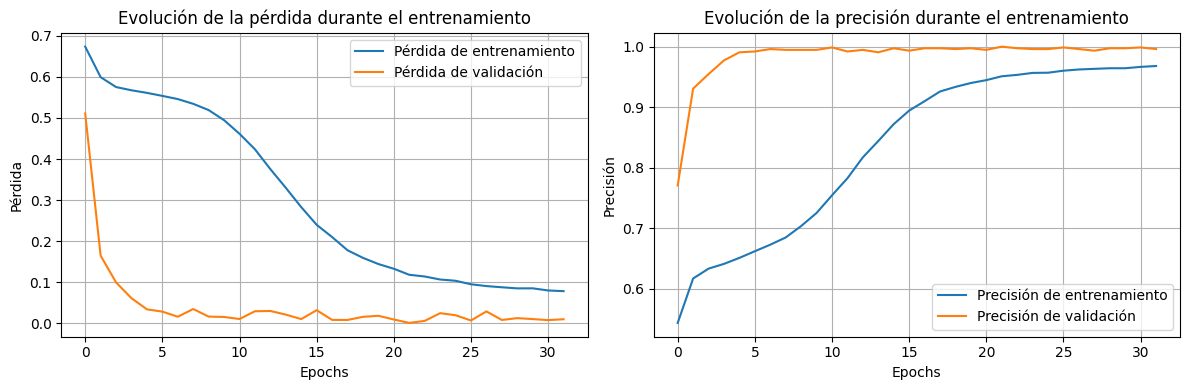

In [6]:
# Grafico la evolucion de perdida para los conjuntos de entrenamiento y prueba durante el entrenamiento
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Gráfico de pérdida
    ax1.plot(history.history['loss'], label='Pérdida de entrenamiento')
    ax1.plot(history.history['val_loss'], label='Pérdida de validación')
    ax1.set_title('Evolución de la pérdida durante el entrenamiento')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Pérdida')
    ax1.legend()
    ax1.grid(True)

    # Gráfico de precisión
    ax2.plot(history.history['accuracy'], label='Precisión de entrenamiento')
    ax2.plot(history.history['val_accuracy'], label='Precisión de validación')
    ax2.set_title('Evolución de la precisión durante el entrenamiento')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Precisión')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

---

<br>
<br>
<br>

## Validando el modelo

Tras el entrenamiento, revisamos la calidad del modelo, enfrentadolo con el conjunto de prueba, y accediendo a las metricas que reflejan las predicciones para este subset.

In [7]:
# Genero predicciones para el conjunto de prueba
y_pred = model.predict(test_data)
y_pred = [1 if p >= 0.5 else 0 for p in y_pred]

conf_matrix = confusion_matrix(test_data.classes, y_pred)
class_report = classification_report(test_data.classes, y_pred)

print(conf_matrix)
print(class_report)

4/4 [==============================] - 1s 250ms/step
[[268   0]
 [  3 235]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       268
           1       1.00      0.99      0.99       238

    accuracy                           0.99       506
   macro avg       0.99      0.99      0.99       506
weighted avg       0.99      0.99      0.99       506



In [8]:
## MÉTRICAS DE CLASIFICACIÓN

print(f"F1-Score ==> {round(f1_score(test_data.labels, y_pred), 3)}")
print(f"Recall ==> {round(recall_score(test_data.labels, y_pred), 3)}")
print(f"Precision ==> {round(precision_score(test_data.labels, y_pred), 3)}")
print(f"Accuracy ==> {round(accuracy_score(test_data.labels, y_pred), 3)}")

F1-Score ==> 0.994
Recall ==> 0.987
Precision ==> 1.0
Accuracy ==> 0.994


En este caso, hemos obtenido unos resultados bastante mejores que en el caso del modelo base. Si bien es cierto que podria utilizar este modelo en produccion, me gustaria tratar de optimizar algo mas el rendimiento. En concreto, debido a que el modelo acaba clasificando 27 instancias como falsos negativos, lo cual queremos tratar de evitar a toda costa. Por el momento, considero fructifero el entrenamiento del modelo, por lo que lo guardo en el directorio correspondiente (**src/trained_models/**).

---

<br>
<br>
<br>

## Comparativa con el modelo base

Una parte del contenido de este notebook constituye el proceso de comparativa del modelo desarrollado, con respecto al modelo que tenemos de base.


#### Evolucion durante entrenamiento MODELO BASE
![](../src/images_notebooks/evolucion_base.png)

---

#### Evolución durante entrenamiento MODELO ACTUAL (aumento de datos; mayor complejidad)
![](../src/images_notebooks/evolucion_aug.png)

Una de las principales diferencias que podemos observar entre el entrenamiento de ambos modelos consistente en la tendencia ascendente al sobreajuste (**overfitting**) del modelo Base. Este modelo no contaba con capas de **Dropout**, ni hacía uso de regularizaciones L1/L2/ElasticNet, por lo que la diferencia de pérdida y precisión entre ambos modelos para el conjunto de entrenamiento es bastante grande.

Si comparamos las métricas de clasificación obtenidas por cada uno de los modelos, con respecto al conjunto de prueba, podemos ver como realmente, estas no distan tanto. De hecho, vemos como, en algunos casos, los coeficientes de las metricas del modelo base reflejan un rendimiento "superior".

#### Métricas clasificación MODELO BASE
![](../src/images_notebooks/metricas_base.png)

---

#### Métricas clasificación MODELO ACTUAL (aumento de datos; mayor complejidad)
![](../src/images_notebooks/metricas_aug.png)


Para el conjunto de prueba actual, el modelo base muestra un rendimiento bastante similar al modelo de mayor complejidad, lo que puede resultar positivo para su despligue en dispositivos móviles, menos potentes (**¡el modelo base pesa tan solo 11 MB!**).

No obstante, podríamos afirmar que el entrenamiento del modelo actual es "mejor", quedando este mucho menos expuesto al sobreajuste. Teniendo en cuenta que nuestro conjunto de datos cuenta, mayoritariamente con radiografías de brazos, muñecas y manos, es probable que el modelo base (estando sobreajustado a este tipo de imágenes) no fuese capaz de clasificar correctemente instancias de radiografías a otras partes del cuerpo.

In [10]:
# Guardo el modelo entrenado
base_model_path = "../src/trained_models/"
model.save(os.path.join(base_model_path, "cnn_aug_data_model.keras"))

print("Modelo guardado correctamente.")

Modelo guardado correctamente.
